In [17]:
from __future__ import division # for puthon 2.7 to make result of division to be float
import time                     # for measure time of procedure execution
import numpy as np
import math
import cv2
import imutils
import skimage.transform
import matplotlib as plt
from sklearn.externals import joblib
from skimage.feature import hog
from skimage.exposure import exposure

In [2]:
from header import *
from train import *
from image_processing import *

In [3]:
def machine_learning():
    print('*' * 20)
    print('MACHINE LEARNING')
    
    execute('=' * 20 + '\nTRAIN', train)

In [4]:
def find_bounds(_mask, _img):
    height, width, channels = _img.shape 
    contours, hierarchy = cv2.findContours(_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounds = []
    for contour in contours:
        [x, y, w, h] = bound = cv2.boundingRect(contour)
        contour_area = cv2.contourArea(contour)
        ellipse_area = (math.pi * (w / 2) * (h / 2))
        if(contour_area < 1000 or y > height*2/3):
            cv2.drawContours(_mask, [contour], -1, 0, -1)
            continue
        if (0.4 < h / w < 2.5) and (w > 20) and (h > 20):
            #if 0.8 < (contour_area / ellipse_area) < 1.2:
                #if True:#check_is_circles(_img[y:y+h, x:x+w]):
            bounds.append(bound)
        else: 
            cv2.drawContours(_mask, [contour], -1, 0, -1)
    return sorted(bounds, key=lambda x: (x[2] * x[3]))

In [5]:
def compare_shape_template(bounds, templates, img):
    methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
             'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
    
    method = eval(methods[0])
    crop_img = []
    
    for bound in bounds:
        [x, y, w, h] = bound
        image_found=img[y:y+h,x:x+w]
        image_found = cv2.resize(image_found, (width, height))
        crop_img.append(cv2.cvtColor(image_found, cv2.COLOR_BGR2RGB))
    

    for crop in crop_img:
        for template in templates:
            w, h, _ = template.shape
            crop_cp = crop.copy()
            plt.imshow(template)
            temp = cv2.matchTemplate(crop_cp,template,method)
            (minVal, maxVal, minLoc, (x, y)) = cv2.minMaxLoc(temp)
            print ("w = {}, h = {}, type = {}".format(w, h, type(temp)))

#     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

In [6]:
def recognize_sign(_img, _mask, _svm, _id):
    bounds = find_bounds(_mask, _img)
    _img = cv2.bitwise_and(_img, _img, mask=_mask)
    for bound in bounds:
        [x, y, w, h] = bound
        
        sign = _img[y:(y + h), x:(x + w)]
        sign = cv2.resize(sign, (width, height))
        class_id = classify_image(sign, _svm)
        
#         if class_id == _id:
        return bound, class_id
    return None, 11

In [7]:
def load_svm():
    pca = joblib.load('pca_and_svm/pca_40.pkl')
    classifier = joblib.load('pca_and_svm/svm_rbf_scale.pkl')
    return pca, classifier

In [8]:
def process_image(_img, _svm, _templates, _templates_title, _frame_id, _info, pca, classifier):
    img = ycrcb_equalize(_img)

    orange_mask = get_mask(img, ['orange'])
    orange_blur = cv2.medianBlur(orange_mask,3)
    blue_mask = get_mask(img, ['blue'])
    blue_blur = cv2.medianBlur(blue_mask,3)
    #filled_img = image_fill(orange_mask)
    #orange_blur = cv2.medianBlur(orange_mask,3)
    wanted_id = 8
    templates_id = blue_templates_id
    temp_blurs = []
    temp_blurs.append(orange_blur)
    temp_blurs.append(blue_blur)
    bounds = find_bounds(temp_blurs[0], _img)
    #compare_shape_template(bounds, _templates, _img)
    for temp_blur in temp_blurs:
        bound, predict_id = recognize_sign(img, temp_blur, _svm, wanted_id)
        if bound is not None:
            [x, y, w, h] = bound
            print(x,y,w,h)
            cv2.rectangle(_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            img0 = img[x:x+w,y+h]
            crop_image0=cv2.resize(img0, (64, 64))

            ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
            descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)

            descriptor_pca=pca.transform(descriptor.reshape(1,-1))
            hog_image_rescaled = exposure.rescale_intensity(imagehog, in_range=(0, 10))
            Predicted_Class=classifier.predict(descriptor_pca)[0]
            cv2.putText(_img, Predicted_Class, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
#     if predict_id == wanted_id:
#         draw(_img, bound, _templates[predict_id - 1], _templates_title[predict_id - 1])
#         [x, y, w, h] = bound
#         _info.append([_frame_id, predict_id, x, y, x + w, y + h, '\n'])
            
    cv2.imshow('result', _img)
    cv2.imshow('filled_img', temp_blurs[0])
    return _img

In [9]:
def process_image_1(_img, _svm, _templates, _templates_title, _frame_id, _info, pca, classifier):
    img = ycrcb_equalize(_img)

    orange_mask = get_mask(img, ['orange'])
    blue_mask = get_mask(img, ['blue'])
    #filled_img = image_fill(orange_mask)
    orange_blur = cv2.medianBlur(orange_mask,3)
    wanted_id = 8
    templates_id = blue_templates_id
    
    bounds = find_bounds(orange_blur, _img)
    #compare_shape_template(bounds, _templates, _img)
    
    bound, predict_id = recognize_sign(img, orange_blur, _svm, wanted_id)
    if bound is not None:
        [x, y, w, h] = bound
        cv2.rectangle(_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        img0 = img[x:x+w,y+h]
        crop_image0=cv2.resize(img0, (64, 64))

        ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
        descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)

        descriptor_pca=pca.transform(descriptor.reshape(1,-1))
        hog_image_rescaled = exposure.rescale_intensity(imagehog, in_range=(0, 10))
        Predicted_Class=classifier.predict(descriptor_pca)[0]
        cv2.putText(_img, Predicted_Class, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
#     descriptor = hog.compute(_image)
#     return int(_svm.predict(np.array([descriptor]))[1][0])
#     if predict_id == wanted_id:
#         draw(_img, bound, _templates[predict_id - 1], _templates_title[predict_id - 1])
#         [x, y, w, h] = bound
#         _info.append([_frame_id, predict_id, x, y, x + w, y + h, '\n'])
            
    cv2.imshow('result', _img)
    cv2.imshow('filled_img', orange_blur)
    return _img

Reading Image from Path:  ./image_and_video/ggggg.png
2


TypeError: 'cv2.HOGDescriptor' object is not callable

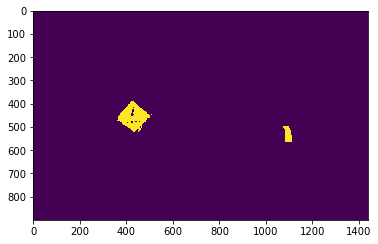

In [70]:
from skimage.exposure import exposure #for displaying th hog image.
pca, classifier = load_svm()
img_path = './image_and_video/ggggg.png'
#img_path='0.jpg'
# img = cv2.imread(img_path)
# svm = execute('Loading model', cv2.ml.SVM_load, svm_model_file)
# templates, templates_title = execute('Loading templates', load_templates)
# info = []
# frame_id = 3

# frame = cv2.resize(img, (normal_width, normal_height))
# r_m = process_image(frame, svm, templates, templates_title, frame_id, info)


print ('Reading Image from Path: ',img_path)
img = cv2.imread(img_path)
orange_mask = get_mask(img, ['orange'])

bounds = find_bounds(orange_mask, img)
print (len(bounds))
img0=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img0 = cv2.medianBlur(img0,3)
crop_image0=cv2.resize(img0, (64, 64))
plt.imshow(orange_mask)
#ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)

descriptor_pca=pca.transform(descriptor.reshape(1,-1))
hog_image_rescaled = exposure.rescale_intensity(imagehog, in_range=(0, 10))
Predicted_Class=classifier.predict(descriptor_pca)[0]
print (Predicted_Class)


# w, h, _ = templates[5].shape
# temp = cv2.matchTemplate(img,cv2.resize(templates[5],(100, 100)),cv2.TM_CCOEFF)
# (minVal, maxVal, minLoc, (x, y)) = cv2.minMaxLoc(temp)
#cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
#cv2.imshow("source", img)

#cv2.waitKey(0)
plt.imshow(orange_mask)

In [10]:
def process_video():
    print('*' * 20)
    print('PROCESS VIDEO')

    print('Init')
    #print (svm_model_file)
    svm = execute('Loading model', cv2.ml.SVM_load, svm_model_file)
    templates, templates_title = execute('Loading templates', load_templates)

    pca, classifier = load_svm()
    
    inp = cv2.VideoCapture(video_input)
    video_width = int(inp.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(inp.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_fps = inp.get(cv2.CAP_PROP_FPS)

    print('Video resolution: (' + str(video_width) + ', ' + str(video_height) + ')')
    print('Video fps:', video_fps)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(video_output, fourcc, video_fps, (normal_width, normal_height))
    print('Video is running')
    info = []

    frame_id = 1
    while inp.isOpened():
        ret, frame = inp.read()
        if (not ret) or (cv2.waitKey(1) & 0xFF == ord('q')):
            break
        frame = cv2.resize(frame, (normal_width, normal_height))
        processed_img = process_image(frame, svm, templates, templates_title, frame_id, info, pca, classifier)
        out.write(processed_img)
        frame_id += 1

    with open(output, 'w') as f:
        f.write(str(len(info)) + '\n')
        for elem in info:
            f.write(' '.join(str(x) for x in elem))

    inp.release()
    out.release()
    cv2.destroyAllWindows()
    print ("end")

In [19]:
process_video()

********************
PROCESS VIDEO
Init
Loading model
Time: 0.123038s
-----
Loading templates
./templates
Time: 0.007059s
-----
Video resolution: (1920, 1072)
Video fps: 30.06318151971113
Video is running
389 281 37 49
388 279 39 50
385 276 39 50
383 272 40 51
380 269 40 53
376 267 41 55
371 265 42 56
365 263 44 57
360 261 45 60
355 260 45 60
349 258 48 61
346 256 48 63
342 253 50 66
339 252 50 68
335 250 52 69
331 247 53 73
325 244 57 76
319 242 57 77
309 238 61 81
300 235 63 83
291 229 64 86
280 224 66 90
267 219 69 92
253 212 72 97
240 206 76 101
229 199 80 105
215 192 84 112
200 184 89 117
185 174 94 122
167 164 100 130
147 152 105 137
121 138 113 146
89 121 121 157
53 102 129 169
11 81 140 182
0 56 118 199
361 278 40 48
359 277 41 48
357 275 40 49
351 274 40 51
345 272 39 52
337 270 40 54
330 270 41 54
324 269 44 55
319 268 44 56
316 266 45 59
314 264 45 60
311 262 46 61
307 260 48 63
303 258 49 65
300 254 51 68
297 251 52 70
292 249 55 71
288 245 56 75
283 243 58 76
279 239 60 79